# Predictive models and biomarkers

In this notebook we are illustrating an alternative to inferential statistics for studing the relationship between neural activity and behavior (intended in a very broad sense).

Let's start as always by importing some modules and functions...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import sys
sys.path.append('../code/')
from utils_neuraldatascience import cohens_d, pred_model_example

sns.set_context('talk')  # draws big plots
sns.set_palette('Set1')  # set the colormap for all plots
plt.rcParams['figure.figsize'] = (10, 6)

## A simple example

In general we want to link brain activity to behaviour. This could mean some cognitive function involved in behavioral tasks but also groups of people that "behave" differently (let me use this term here although sometimes the difference in behavior can be subtle or difficult to measure).

Let's say we estimate the value of functional connectivity between frontal and temporal lobes for several subjects affected by Alzheimer's disease and several control subjects.
We want to know if the connectivity is altered in AD patients compared to cotrols.

Let's make up some data.
The histograms of the two groups might look something like this. 

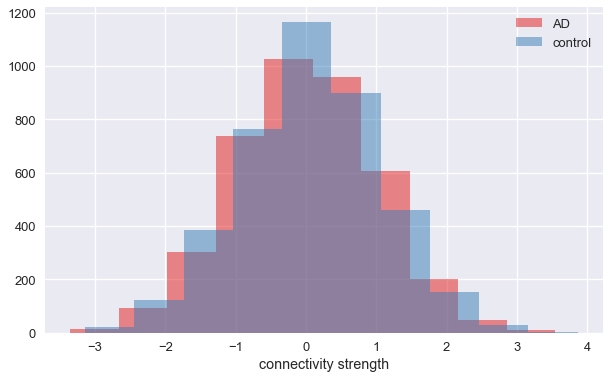

In [19]:
d = .1  # difference between means
mu0 = 0.  # mean of AD
mu1 = mu0 + d  ## mean of controls
sigma = 1.  # common standard deviation
n0 = 4000  # number of patients
n1 = 4000  # number of controls
a = np.random.normal(mu0, sigma, n0)  # sampling from Gaussian
b = np.random.normal(mu1, sigma, n1)  # sampling from Gaussian
plt.figure()
plt.hist(a, alpha=0.5, label='AD')
plt.hist(b, alpha=0.5, label='control')
plt.xlabel('connectivity strength')
plt.legend()
plt.show()

Now this is very simple since we have just one variable and two group.

We can just inspect the histogram. Is the connectivity strength altered in AD?

As you already know in order to formally test if there is a difference beyond appaerence we could run a t-test and check __if the difference is statistically significant__.

In [17]:
print("p-value = %1.2e" %(ttest_ind(a, b)[1]))

p-value = 3.21e-02


If this value is small enough we are very happy. But...

How does the p-value change if we had access to a different number of samples (without changing the underlying population)?

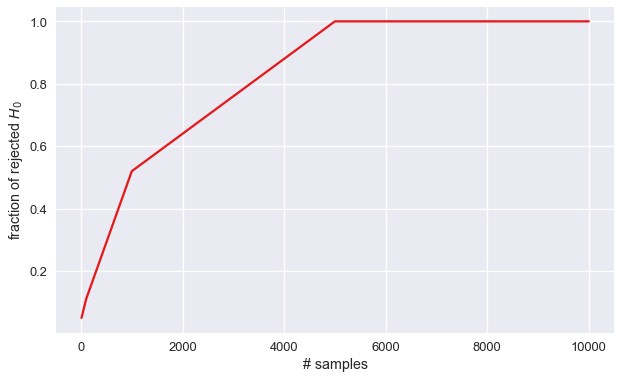

In [20]:
# show dependence of p-value on N
M = 100
Ns = [10, 100, 1000, 5000, 10000]
rej = np.zeros(len(Ns), dtype=int)
pvals = np.zeros([len(Ns), M])
pmann = np.zeros([len(Ns), M])
for i, n in enumerate(Ns):
    for m in range(M):
        c = np.random.normal(mu0, sigma, n)  # sampling from Gaussian
        d = np.random.normal(mu1, sigma, n)  # sampling from Gaussian
        pvals[i, m] = ttest_ind(c, d)[1]

# fraction of rejected null-hypotheses
rej_tt = [np.sum(pvals[i, :] < 0.05) / M for i in range(len(Ns))]
plt.figure()
plt.plot(Ns, rej_tt)
plt.xlabel('# samples')
plt.ylabel(r'fraction of rejected $H_0$')
plt.show()

So, if the p-value is significant...

Does this actually mean that the link strength is informative about the disease? 

Is it possible to use it as a diagnostic variable? 

Can you identify AD patients from controls based on the link strenght?

In order to answer this questions we actually need to look at the __effect size__ not __p-value__.

In [29]:
print("Cohen's d = %1.2e" %cohens_d(a, b))

Cohen's d = 1.27e-01


Effect size tells us if the variable we are looking at really distinguishes the two groups.

## Predictive models

As an alternative to inferential statistics we can use the strength of the estimated connectivity for each subject to directly predict the group they belong to. At the end this was what we wanted, right? A biomarker for AD. 

Thus we need to define a model that maps from the connectivity strength to the groups and we need to estimate model parameters from data. We can then make predictions for each data point and evaluate the __prediction accuracy__. If the prediction is accurate the variable used (connectivity strength) is informative about the group (note that the converse is not necessarily true: the accuracy can be low also due to parameter estimation error or model mispecification).

The following code defines and estimates a model to predict the group of our synthetic data (don't worry about details, everything we'll talk about it in the Machine Learning session).

In [21]:
# concatenate the two groups together
X = np.vstack([a[:, np.newaxis], b[:, np.newaxis]])
# the variable we want to predict (the group of each subject, coding is arbitrary)
y = np.array([0 if i<n0 else 1 for i in range(n0+n1)])

accuracy = pred_model_example(X, y)
print("classification accuracy = %1.2f" %(accuracy.mean()))

classification accuracy = 0.52


Since both groups have the same number of subjects if accuracy is near 0.5 our model (and the neural activity it's based upon) is not better than tossing a coin.
In some sense prediction accuracy takes into account both effect size and p-value. The advantage is that it directly gives an easily interpretable measure of how informative the neural activity (or connectivity in this case) is about our variable .

If the variable that we are predicting is a categorical variable the prediction task is a __classification__; if the variable to predict is continuous we have a __regression__ task. There are some differences between the two that we will see in the Machine Learning session but both share the same framework.

There are several __advantages of predictive models__:

1) multiple hypothesis testing is not an issue since the focus is not on the probability of the effect

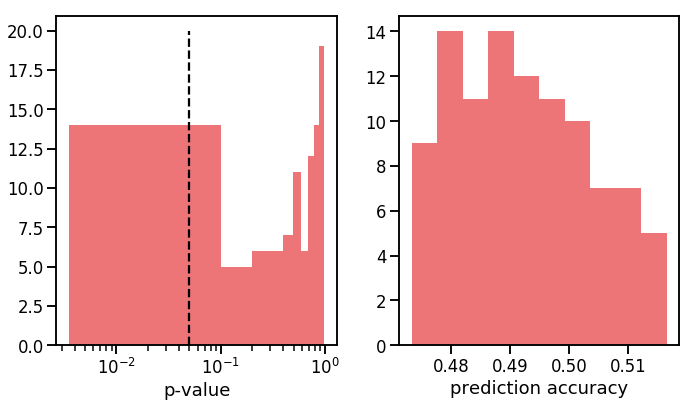

In [83]:
M = 100
pvals = np.zeros(M)
mean_accuracy = np.zeros(M)
for m in range(M):
    a = np.random.normal(0, sigma, n0)  # sampling from Gaussian
    b = np.random.normal(0, sigma, n1)  # sampling from Gaussian
    X = np.vstack([a[:, np.newaxis], b[:, np.newaxis]])
    y = np.array([0 if i<n0 else 1 for i in range(n0+n1)])
    mean_accuracy[m] = pred_model_example(X, y).mean()
    pvals[m] = ttest_ind(a, b)[1]

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pvals, alpha=0.6)
plt.xscale('log')
ylims = plt.ylim()
plt.plot([0.05, 0.05], ylims, '--k')
plt.xlabel('p-value')
plt.subplot(1, 2, 2)
plt.hist(mean_accuracy, alpha=0.6)
plt.xlabel('prediction accuracy')
plt.tight_layout()
plt.show()

2) naturally multivariate (thus further mitigating the problem of MHT): exploit information encoded in the covariance of features

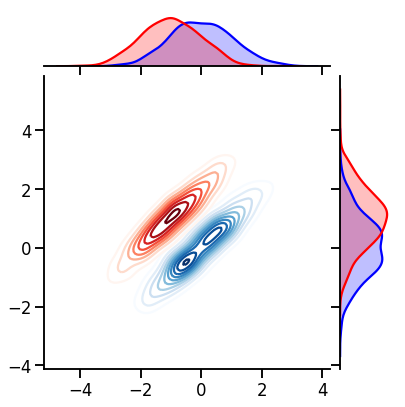

In [84]:
n_samples = 1000
mus = [.0, .0]
cov = np.array([[1, .95],[.95, 1]])
X1 = np.random.multivariate_normal(mean=mus, cov=cov, size=n_samples)
g = sns.jointplot(x=X1[:, 0], y=X1[:, 1], shade=False, kind="kde", stat_func=None, cmap='Blues', color='blue')
delta = 1.
mus = [-delta, delta]
X2 = np.random.multivariate_normal(mean=mus, cov=cov, size=n_samples)
g.x = X2[:, 0]
g.y = X2[:, 1]
g = g.plot_joint(sns.kdeplot, shade=False, cmap='Reds')
g = g.plot_marginals(sns.kdeplot, shade=True, color='red')
plt.show()

3) model mispecification (violation of assumption) can only produce type II errors (miss or false negative)